<a href="https://colab.research.google.com/github/Tyronita/BathHack2022/blob/main/D1_and_D2_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load in data

In [1]:
from google.colab import drive
import json
import os
drive.mount('/content/drive')

HOME = os.getcwd()
print(HOME)

# Define the path to the JSON file on your Google Drive
time_space_track_path =  f'/{HOME}/drive/My Drive/Machine-Learning/people-counting-track.json'

# Load the JSON file
with open(time_space_track_path, 'r') as json_file:
    time_space_track = json.load(json_file)

Mounted at /content/drive
/content


# attack d2 - detect pacing

-  [x1, y1, x2, y2] where x1,y1 is the top-left corner, x2,y2 is the bottom-right corner of the bounding box.

## transform bounding boxes 4x1 -> 2x1 (2d coord)
- to by-centre
- to by-feet



In [2]:
def centre_position(box): # 4X1 = 2X1
  # midpoint of TopL and BottomR coords
  [x1, y1, x2, y2] = box
  return [(x1 + x2)/2, (y1 + y2)/2]

def feet_position(box): # 4X1 = 2X1
  # mid of x's but bottom y coord
  [x1, y1, x2, y2] = box
  return [(x1 + x2)/2, y2]

In [3]:
by_centre = []
by_feet = []

for detection_list in time_space_track:
  new_centre_list = []
  new_feet_list = []
  for detection in detection_list:
    id = detection['tracker_id']
    bbx = detection['bounding_box']
    new_centre_list.append({'tracker_id': id, 'bounding_box': centre_position(bbx)})
    new_feet_list.append({'tracker_id': id, 'bounding_box': feet_position(bbx)})
  by_centre.append(new_centre_list)
  by_feet.append(new_feet_list)

# Would like to plot tracker id_against time
- also do space against time
- lets use tracker_id as key:

{tracker_id:[{start:, end:, length:}]}

In [4]:
# elapses = [{start:, end:, length:, }]
elapses = {}
last_seen_ids = []

# allowance frames is the amount of frames we can disregard for losing track of an object
ALLOWANCE_FRAMES = 5 # approx 0.4s

for frame_number, detection_list in enumerate(by_feet): #btw the fps = 25

  if frame_number == 0:
    last_seen_ids = [x['tracker_id'] for x in by_feet[0]]
    queue = {id: [0, 0] for id in last_seen_ids}
    continue

  new_ids = [ x['tracker_id'] for x in detection_list]

  to_update = [x for x in new_ids if x in queue]
  for id in to_update:
    first_spotted, last_spotted = queue[id]
    queue[id] = [first_spotted, frame_number]

  to_add = [x for x in new_ids if x not in queue]
  for id in to_add:
    queue[id] = [frame_number, frame_number]

  to_remove = [x for x in queue if x not in new_ids and frame_number - queue[x][1] > ALLOWANCE_FRAMES]
  for id in to_remove:
    start, end = queue[id][0], frame_number
    entry = {'start': start, 'end': end, 'length': end - start}
    if id not in elapses:
      elapses[id] = [entry]
    else:
      elapses[id].append(entry)
    queue.pop(id, None)

# residual lengths
for id in queue:
  start = queue[id][0]
  end = len(by_feet) - 1
  last_entry = {'start': start, 'end': end, 'length': end - start}
  if id in elapses:
    elapses[id] += [last_entry]
  else:
    elapses[id] = [last_entry]


In [5]:
# transform to by_id and add displacement
def disp_and_by_id(list_thing):
  res = {}
  for frame_number, detection_list in enumerate(list_thing):
    for detection in detection_list:
      id, xy = detection['tracker_id'], detection['bounding_box']
      if id in res:
        xOriginal, yOriginal = res[id][0]['position']
        x, y = xy
        res[id] += [{'time': frame_number, 'position': xy, 'displacement': round((x - xOriginal)**2 + (y - yOriginal)**2, 2)}]
      else:
        res[id] = [{'time': frame_number, 'position': xy, 'displacement': 0}]
  return res


# Chasing D2 - pacing volatility


In [6]:
feet_by_id = disp_and_by_id(by_feet)
print(feet_by_id)

{45: [{'time': 0, 'position': [717.2476806640625, 272.0595397949219], 'displacement': 0}, {'time': 1, 'position': [717.234375, 272.0552062988281], 'displacement': 0.0}, {'time': 2, 'position': [717.2348022460938, 272.0531921386719], 'displacement': 0.0}, {'time': 3, 'position': [717.0555419921875, 273.25054931640625], 'displacement': 1.46}, {'time': 4, 'position': [717.8475341796875, 272.79266357421875], 'displacement': 0.9}, {'time': 5, 'position': [717.7913818359375, 272.76708984375], 'displacement': 0.8}, {'time': 6, 'position': [715.238037109375, 273.19244384765625], 'displacement': 5.32}, {'time': 7, 'position': [715.1134033203125, 273.02423095703125], 'displacement': 5.49}, {'time': 8, 'position': [715.0965576171875, 273.0533142089844], 'displacement': 5.61}, {'time': 9, 'position': [715.1671142578125, 273.649658203125], 'displacement': 6.86}, {'time': 10, 'position': [711.3817138671875, 284.2361145019531], 'displacement': 182.68}, {'time': 11, 'position': [711.3304443359375, 284

In [7]:
def get_time_space(id):
  ind = feet_by_id[id]
  time, disp = [x['time'] for x in ind], [x['displacement'] for x in ind]
  return time, disp

In [8]:
import matplotlib.pyplot as plt
import numpy as np



In [9]:
def analyse (start_id, end_id):

  # Set the figure size (width, height)
  plt.figure(figsize=(8, 5))
  plt.xlabel('Time')
  plt.ylabel('Displacement')
  plt.title('Displacement Over Time')

  # calculate std/vol and plot line
  stds = {}
  for x in range(start_id, end_id+1):
    time, disp = get_time_space(x)
    stds[x] = np.array(disp).std() * np.sqrt(len(time))
    if len(time) != len(disp):
      break
    plt.plot(time, disp, linestyle='-', label=f'{x}')

  # add std to legend
  handles, labels = plt.gca().get_legend_handles_labels()  # Get the handles and labels of the plotted lines
  labels = [ x + f" - vol {round(stds[int(x)], 1)}" for x in labels]

  plt.legend(handles, labels)


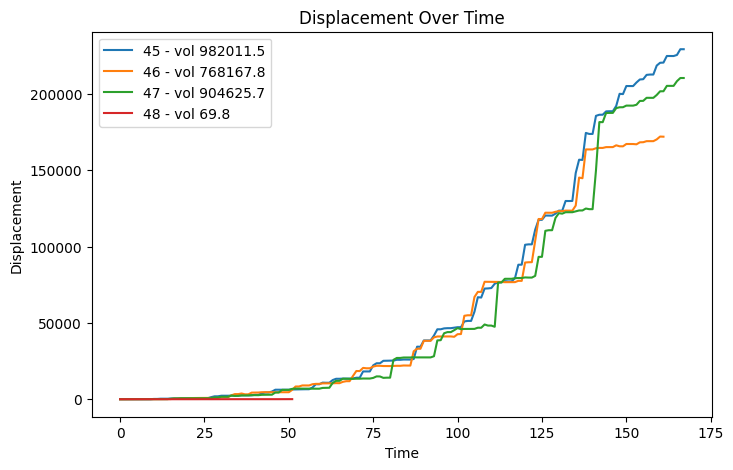

In [10]:
analyse(45, 48)